In [41]:
from tqdm.auto import tqdm
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from typing import List, Dict, Tuple, Optional, Union
from dataclasses import dataclass
import json
import os
from pathlib import Path

In [24]:

@dataclass
class FontDescription:
    detailed_description: str
    technical_characteristics: List[str]
    personality_traits: List[str]
    practical_contexts: List[str]
    cultural_intuition: List[str]
    search_keywords: List[str]

    @classmethod
    def from_dict(cls, data: Dict) -> 'FontDescription':
        return cls(**data)

class VectorFontSearch:
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', images_dir: Optional[str] = None):
        """Initialize the vector-based font search system."""
        self.model = SentenceTransformer(model_name)
        self.dimension = self.model.get_sentence_embedding_dimension()
        self.images_dir = Path(images_dir) if images_dir else None
        
        # Store embeddings separately for better management
        self.embeddings = []
        self.documents = []
        
        # Start with simple flat index
        self.index = faiss.IndexFlatIP(self.dimension)  # Use inner product for better semantic matching
        
        # Normalize vectors for cosine similarity
        self.normalize = True

    def _normalize_vector(self, vector: np.ndarray) -> np.ndarray:
        """Normalize vector for cosine similarity."""
        if self.normalize:
            faiss.normalize_L2(vector)
        return vector

    def _create_searchable_text(self, font_data: Dict) -> str:
        """Create weighted searchable text from font document."""
        desc = font_data['description']
        
        # Weighted components
        components = [
            desc['detailed_description'] * 2,  # High weight for detailed description
            ' '.join(desc['technical_characteristics']) * 2,
            ' '.join(desc['personality_traits']) * 3,  # Higher weight for personality
            ' '.join(desc['practical_contexts']) * 2,
            ' '.join(desc['cultural_intuition']) * 2,
            ' '.join(desc['search_keywords']) * 3  # Higher weight for keywords
        ]
        
        return ' '.join(components)

    def add_fonts(self, font_data_list: List[Dict], batch_size: int = 32) -> None:
        """Add fonts to the search index."""
        for font_data in font_data_list:
            # Create searchable text
            text = self._create_searchable_text(font_data)
            
            # Compute embedding
            embedding = self.model.encode([text], 
                                       show_progress_bar=False,
                                       normalize_embeddings=self.normalize)
            
            # Store font data and embedding
            self.documents.append(font_data)
            self.embeddings.append(embedding[0])
            
            # Add to index
            self.index.add(embedding)
            
        # print(f"Added {len(font_data_list)} fonts. Total fonts: {len(self.documents)}")

    def search(self, query: str, k: int = 10, include_scores: bool = True) -> List[Dict]:
        """
        Search for similar fonts.
        
        Args:
            query: Search query
            k: Number of results to return
            include_scores: Whether to include similarity scores
        """
        # Encode query
        query_vector = self.model.encode([query], 
                                       show_progress_bar=False,
                                       normalize_embeddings=self.normalize)
        
        # Search
        scores, indices = self.index.search(query_vector, k)
        
        # Prepare results
        results = []
        for score, idx in zip(scores[0], indices[0]):
            if idx != -1:
                font = self.documents[idx]
                
                result = {
                    'filename': font['filename'],
                    'description': font['description']['detailed_description'],
                    'keywords': font['description']['search_keywords'],
                }
                
                if self.images_dir:
                    image_path = self.images_dir / font['filename']
                    if image_path.exists():
                        result['image'] = str(image_path)
                
                if include_scores:
                    # Convert to similarity score (0-1 range)
                    result['score'] = float(score)
                    
                # Add relevant metadata
                result['technical_characteristics'] = font['description']['technical_characteristics']
                result['personality_traits'] = font['description']['personality_traits']
                result['practical_contexts'] = font['description']['practical_contexts']
                
                results.append(result)
        
        return results

    def save(self, directory: str) -> None:
        """Save the search index and data."""
        os.makedirs(directory, exist_ok=True)
        directory = Path(directory)
        
        # Save index
        faiss.write_index(self.index, str(directory / 'font_index.faiss'))
        
        # Save embeddings
        np.save(str(directory / 'embeddings.npy'), np.array(self.embeddings))
        
        # Save documents
        with open(directory / 'documents.json', 'w') as f:
            json.dump(self.documents, f, indent=2)

    @classmethod
    def load(cls, directory: str, model_name: str = 'all-MiniLM-L6-v2', 
             images_dir: Optional[str] = None) -> 'VectorFontSearch':
        """Load a saved search index and data."""
        directory = Path(directory)
        instance = cls(model_name, images_dir)
        
        # Load index
        instance.index = faiss.read_index(str(directory / 'font_index.faiss'))
        
        # Load embeddings
        instance.embeddings = np.load(str(directory / 'embeddings.npy')).tolist()
        
        # Load documents
        with open(directory / 'documents.json', 'r') as f:
            instance.documents = json.load(f)
        
        return instance

def example_usage():
    # Initialize search
    search = VectorFontSearch(images_dir="rendered_fonts")
    
    # Add fonts
    font_files = [f for f in os.listdir('font_descriptions') if f.endswith('.json')]
    
    for file in tqdm(font_files):
        try:
            with open(os.path.join('font_descriptions', file), 'r') as f:
                font_data = json.load(f)
                search.add_fonts([font_data])
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Example searches
    queries = [
        "urban graffiti style font",
        "professional business typeface",
        "playful hand-drawn display font"
    ]
    
    for query in queries:
        print(f"\nSearching for '{query}':")
        results = search.search(query, k=5)
        for result in results:
            print(f"Score: {result['score']:.3f}")
            print(f"Font: {result['filename']}")
            print("Description:", result['description'][:100], "...")
            print("Keywords:", result['keywords'])
            if 'image' in result:
                print("Image:", result['image'])
            print("---")
    
    return search

search = example_usage()

  0%|          | 0/2209 [00:00<?, ?it/s]

Error processing bringshoot_36px.json: 'description'

Searching for 'urban graffiti style font':
Score: 0.753
Font: a_arena_graffiti_36px.png
Description: This font embodies the raw energy and rebellious spirit of urban graffiti. Its construction is decid ...
Keywords: ['graffiti font', 'urban font', 'street art font', 'bold font', 'dynamic font', 'rebellious font', 'raw font', 'spontaneous font', 'energetic font', 'underground font', 'headline font', 'logo font', 'branding font', 'urban design', 'street art design']
Image: rendered_fonts\a_arena_graffiti_36px.png
---
Score: 0.748
Font: bway_36px.png
Description: This font is a bold expression of urban energy, drawing heavily from the visual language of graffiti ...
Keywords: ['graffiti font', 'urban font', 'street art font', 'bold font', 'dynamic font', 'chaotic font', 'rebellious font', 'streetwear font', 'hip-hop font', 'large-scale font', 'signage font', 'poster font', 'headline font', 'title font', 'urban design', 'street culture'

In [26]:
search.save('font_search_index_2000')

In [28]:
search = search.load('font_search_index_2000')

(((o)))_basic_72px
This font is a minimalist sans-serif typeface characterized by its clean lines, geometric shapes, and open forms. The letters are constructed from a limited number of straight and curved lines, creating a simple and elegant aesthetic. The font's overall appearance is modern and contemporary, with a touch of futuristic flair. The lowercase letters are particularly distinctive, with their unique shapes and proportions. The font includes a full set of uppercase and lowercase letters, numbers, punctuation marks, and symbols.
['sans-serif', 'geometric', 'minimalist', 'linear', 'modern', 'contemporary', 'futuristic', 'clean', 'simple', 'elegant', 'bold', 'strong', 'minimal', 'technical', 'functional', 'efficient', 'streamlined', 'logo', 'branding', 'web design', 'mobile app', 'interface', 'typography', 'heading', 'title', 'poster', 'flyer', 'brochure', 'magazine', 'layout', 'product', 'packaging', 'editorial', 'design', 'futurism', 'modernism', 'minimalism', 'technology', 

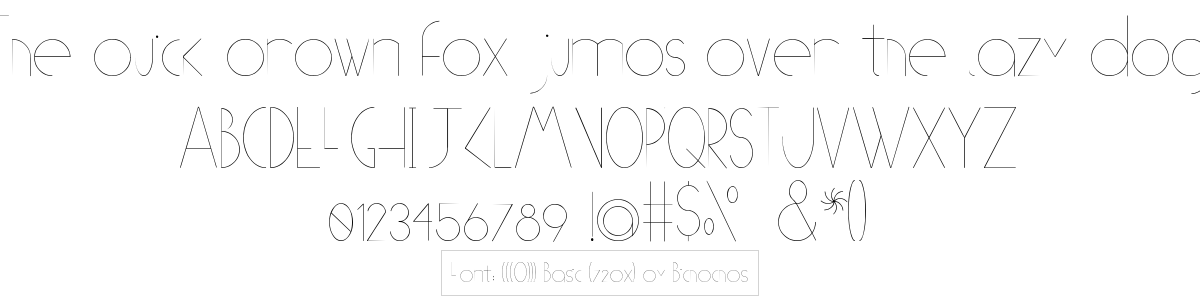

5_champagne_unicase_48px
This font is a sans-serif typeface with a clean, modern aesthetic. It features a geometric construction with sharp angles and a consistent stroke weight. The characters are well-spaced and legible, making it suitable for a variety of applications. The font has a slightly condensed feel, which adds a touch of dynamism to its overall appearance.
['sans-serif', 'geometric', 'condensed', 'modern', 'clean', 'sharp', 'legible', 'professional', 'website', 'branding', 'logo', 'editorial', 'interface']
0.6263490319252014


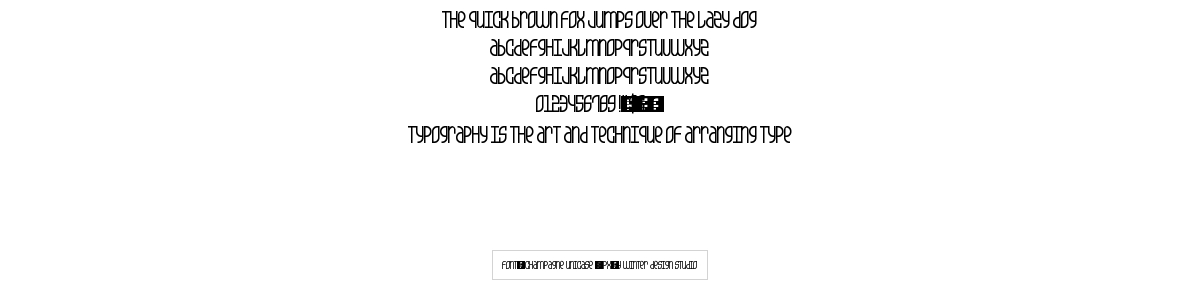

5_computers_in_love_72px
This font is a bold, geometric sans-serif typeface with a distinct pixelated aesthetic. Its characters are composed of simple, rectangular shapes, creating a clean and modern look. The font's bold weight and sharp edges give it a strong and assertive presence, while the pixelated style adds a touch of retro charm and a nod to digital origins. The overall effect is a font that is both contemporary and nostalgic, suitable for a variety of design applications.
['pixel', 'geometric sans-serif', 'bold sans-serif', 'retro font', 'digital font', 'monospaced font', 'game font', 'futuristic font', 'cyberpunk font', 'minimal font']
0.6134105920791626


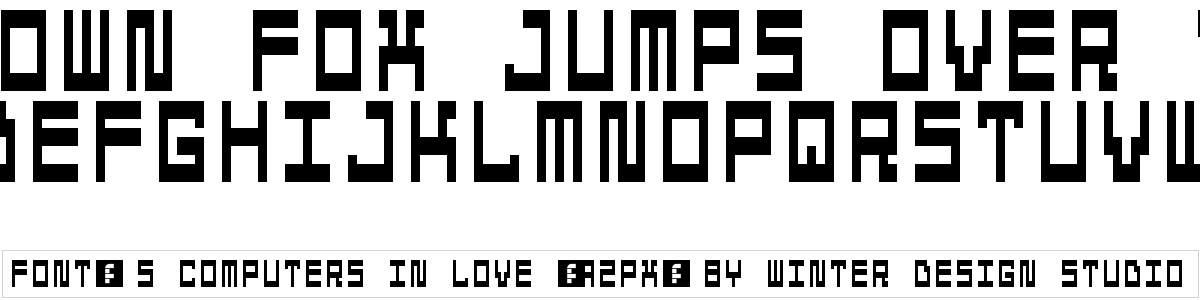

222
This font is a bold and playful take on geometric sans-serif design, drawing inspiration from both classic and contemporary styles. Its construction is based on simple, rounded shapes, with each letterform built from a series of connected curves and straight lines. The rounded corners and generous curves give the font a friendly and approachable feel, while the bold weight and consistent stroke width create a strong and confident presence. The font's high x-height and open counters ensure excellent legibility, even at small sizes, making it suitable for a wide range of applications, from headlines and branding to digital interfaces and signage. Its playful nature and bold presence make it ideal for projects that require a strong visual impact and a touch of retro charm, evoking a sense of fun and energy that resonates with contemporary design trends.
['Geometric sans-serif', 'Rounded corners', 'Bold weight', 'High x-height', 'Open counters', 'Retro', 'Playful', 'Energetic', 'Vibran

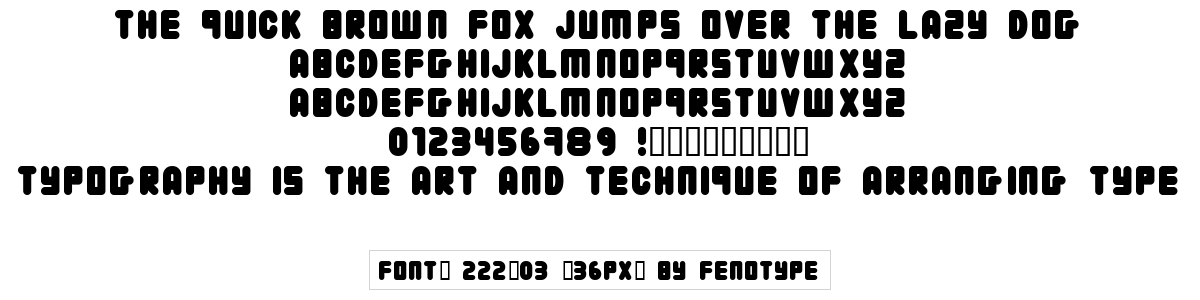

212_keyboard_36px
This font is a simple, sans-serif typeface that resembles the keys on a standard computer keyboard. It features a bold, blocky design with rounded corners and a slight shadow effect. The characters are well-spaced and easy to read, making it suitable for a variety of applications.
['keyboard', 'sans-serif', 'bold', 'rounded', 'shadow', 'blocky', 'retro', 'modern', 'clean', 'functional', 'interface', 'website', 'logo', 'button', 'icon', 'game', 'educational']
0.6049975156784058


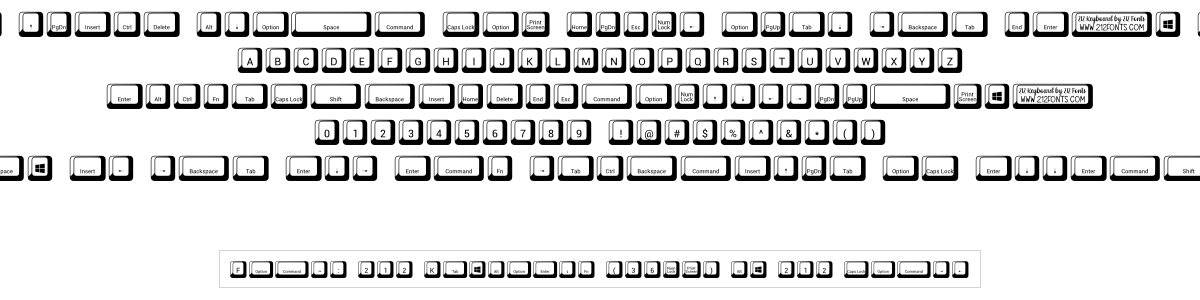

In [40]:
# search some queries

query = "modern sans-serif font"

results = search.search(query, k=5)

IMG_DIR = './rendered_fonts'
for result in results:
    # plot the image, font name, description, keywords
    print(result['filename'].split('.')[0])
    print(result['description'])
    print(result['keywords'])
    print(result['score'])
    
    # plot the image
    from PIL import Image
    img = Image.open(os.path.join(IMG_DIR, result['filename']))
    display(img)

In [48]:
# vector_font_search.py
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from typing import List, Dict, Optional, Any
from pathlib import Path
import json
import os
import shutil
import pickle
from datetime import datetime

class VectorFontSearch:
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', 
                 images_dir: Optional[str] = None):
        """Initialize the vector-based font search system."""
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        self.dimension = self.model.get_sentence_embedding_dimension()
        self.images_dir = Path(images_dir) if images_dir else None
        
        # Initialize storage
        self.documents = []
        self.index = faiss.IndexFlatIP(self.dimension)
        
        # Metadata
        self.metadata = {
            "model_name": model_name,
            "dimension": self.dimension,
            "created_at": datetime.now().isoformat(),
            "num_documents": 0,
            "last_updated": None
        }

    def save(self, save_dir: str) -> None:
        """
        Save the complete search state including index, documents, and metadata.
        
        Args:
            save_dir: Directory to save the search state
        """
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        
        try:
            # Update metadata
            self.metadata.update({
                "num_documents": len(self.documents),
                "last_updated": datetime.now().isoformat()
            })
            
            # Save FAISS index
            index_path = save_dir / "font_index.faiss"
            faiss.write_index(self.index, str(index_path))
            
            # Save documents
            docs_path = save_dir / "documents.json"
            with open(docs_path, 'w', encoding='utf-8') as f:
                json.dump(self.documents, f, ensure_ascii=False, indent=2)
            
            # Save metadata
            meta_path = save_dir / "metadata.json"
            with open(meta_path, 'w', encoding='utf-8') as f:
                json.dump(self.metadata, f, ensure_ascii=False, indent=2)
                
            print(f"Successfully saved search state to {save_dir}")
            print(f"- Documents: {len(self.documents)}")
            print(f"- Index size: {os.path.getsize(index_path) / 1024 / 1024:.2f} MB")
            
        except Exception as e:
            print(f"Error saving search state: {str(e)}")
            raise

    @classmethod
    def load(cls, save_dir: str, images_dir: Optional[str] = None) -> 'VectorFontSearch':
        """
        Load a complete search state from disk.
        
        Args:
            save_dir: Directory containing the saved search state
            images_dir: Optional new images directory
        
        Returns:
            VectorFontSearch: Loaded search instance
        """
        save_dir = Path(save_dir)
        
        try:
            # Load metadata first to get model name
            meta_path = save_dir / "metadata.json"
            with open(meta_path, 'r', encoding='utf-8') as f:
                metadata = json.load(f)
            
            # Create instance with same model
            instance = cls(model_name=metadata["model_name"], images_dir=images_dir)
            instance.metadata = metadata
            
            # Load FAISS index
            index_path = save_dir / "font_index.faiss"
            instance.index = faiss.read_index(str(index_path))
            
            # Load documents
            docs_path = save_dir / "documents.json"
            with open(docs_path, 'r', encoding='utf-8') as f:
                instance.documents = json.load(f)
            
            print(f"Successfully loaded search state from {save_dir}")
            print(f"- Model: {instance.model_name}")
            print(f"- Documents: {len(instance.documents)}")
            print(f"- Last updated: {metadata.get('last_updated', 'unknown')}")
            
            return instance
            
        except Exception as e:
            print(f"Error loading search state: {str(e)}")
            raise

    def add_fonts(self, font_data_list: List[Dict]) -> None:
        """Add fonts to the search index."""
        if not font_data_list:
            return

        try:
            # Prepare batch of texts
            texts = [self._create_searchable_text(font) for font in font_data_list]
            
            # Compute embeddings
            embeddings = self.model.encode(texts, 
                                         show_progress_bar=False,
                                         normalize_embeddings=True)
            
            # Add to index
            self.index.add(embeddings)
            
            # Store documents
            self.documents.extend(font_data_list)
            
            # print(f"Added {len(font_data_list)} fonts. Total: {len(self.documents)}")
                
        except Exception as e:
            print(f"Error adding fonts: {str(e)}")

    def search(self, query: str, k: int = 10) -> List[Dict]:
        """Search for similar fonts."""
        if not self.documents:
            print("Warning: No documents in index")
            return []

        try:
            # Encode query
            query_vector = self.model.encode([query], 
                                           show_progress_bar=False,
                                           normalize_embeddings=True)
            
            # Search
            scores, indices = self.index.search(query_vector, min(k, len(self.documents)))
            
            # Prepare results
            results = []
            for score, idx in zip(scores[0], indices[0]):
                if idx != -1 and idx < len(self.documents):
                    font = self.documents[idx]
                    
                    result = {
                        'filename': font['filename'],
                        'description': font['description']['detailed_description'],
                        'technical_characteristics': font['description']['technical_characteristics'],
                        'personality_traits': font['description']['personality_traits'],
                        'practical_contexts': font['description']['practical_contexts'],
                        'search_keywords': font['description']['search_keywords'],
                        'score': float(score)
                    }
                    
                    if self.images_dir:
                        image_path = self.images_dir / font['filename']
                        if image_path.exists():
                            result['image'] = str(image_path)
                    
                    results.append(result)
            
            return results
            
        except Exception as e:
            print(f"Search error: {str(e)}")
            return []

    def _create_searchable_text(self, font_data: Dict) -> str:
        """Create weighted searchable text from font document."""
        desc = font_data['description']
        
        components = [
            desc['detailed_description'] * 2,
            ' '.join(desc['technical_characteristics']) * 2,
            ' '.join(desc['personality_traits']) * 3,
            ' '.join(desc['practical_contexts']) * 2,
            ' '.join(desc['cultural_intuition']) * 2,
            ' '.join(desc['search_keywords']) * 3
        ]
        
        return ' '.join(components)

In [ ]:
# example_usage
from tqdm.auto import tqdm
import json
import os

search = VectorFontSearch(images_dir="rendered_fonts")

# Add fonts
font_files = [f for f in os.listdir('font_descriptions') if f.endswith('.json')]
for file in tqdm(font_files):
    with open(os.path.join('font_descriptions', file), 'r') as f:
        font_data = json.load(f)
        search.add_fonts([font_data])

# Example searches
queries = [
    "urban graffiti style font",
    "professional business typeface",
    "playful hand-drawn display font"
]

for query in queries:
    print(f"\nSearching for '{query}':")
    results = search.search(query, k=5)
    for result in results:
        print(f"Score: {result['score']:.3f}")
        print(f"Font: {result['filename']}")
        print("Description:", result['description'][:100], "...")
        print("Keywords:", result['search_keywords'])
        if 'image' in result:
            print("Image:", result['image'])
        print("---")        

In [49]:
search.save('serving_index')

Successfully saved search state to serving_index
- Documents: 3399
- Index size: 4.98 MB


In [50]:
search2 = VectorFontSearch.load('serving_index')

Successfully loaded search state from serving_index
- Model: all-MiniLM-L6-v2
- Documents: 3399
- Last updated: 2024-11-10T06:24:27.713868



Searching for 'urban graffiti style font':
Score: 0.753
Font: a_arena_graffiti_36px.png
Description: This font embodies the raw energy and rebellious spirit of urban graffiti. Its construction is decid ...
Keywords: ['graffiti font', 'urban font', 'street art font', 'bold font', 'dynamic font', 'rebellious font', 'raw font', 'spontaneous font', 'energetic font', 'underground font', 'headline font', 'logo font', 'branding font', 'urban design', 'street art design']


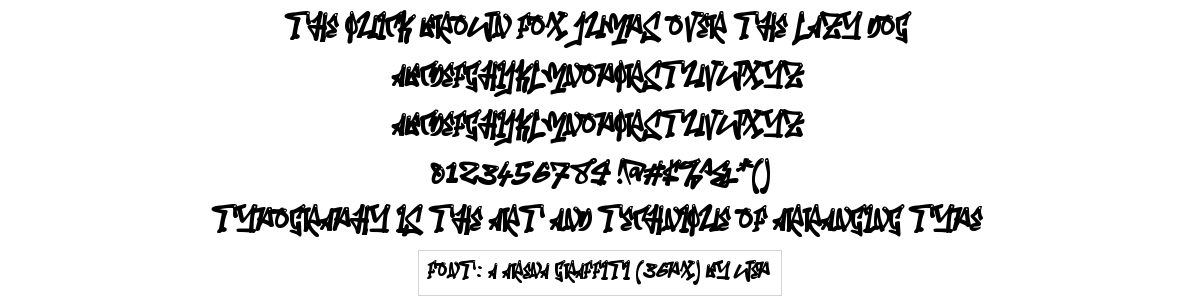

---
Score: 0.748
Font: bway_36px.png
Description: This font is a bold expression of urban energy, drawing heavily from the visual language of graffiti ...
Keywords: ['graffiti font', 'urban font', 'street art font', 'bold font', 'dynamic font', 'chaotic font', 'rebellious font', 'streetwear font', 'hip-hop font', 'large-scale font', 'signage font', 'poster font', 'headline font', 'title font', 'urban design', 'street culture', 'graffiti art', 'rebellion', 'individuality']


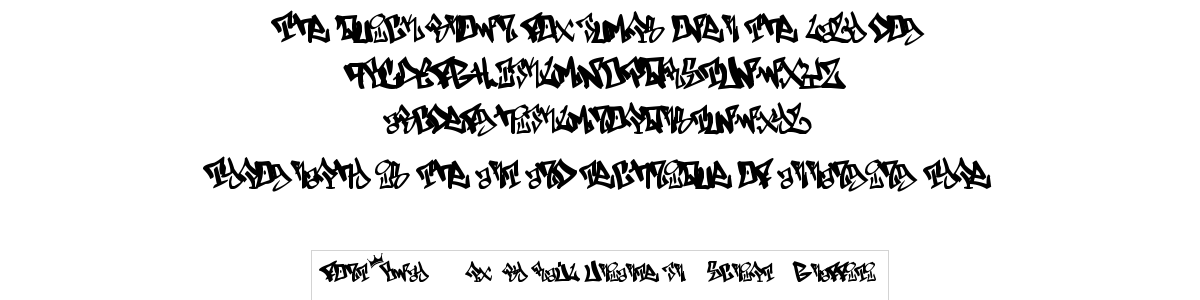

---
Score: 0.728
Font: chronic_36px.png
Description: This font, with its bold, gestural strokes and irregular letterforms, embodies the raw energy and sp ...
Keywords: ['graffiti font', 'street art font', 'handwritten font', 'brush script', 'urban font', 'bold font', 'expressive font', 'informal font', 'digital font', 'youthful font', 'rebellious font', 'creative font', 'individualistic font', 'unconventional font', 'dynamic font']


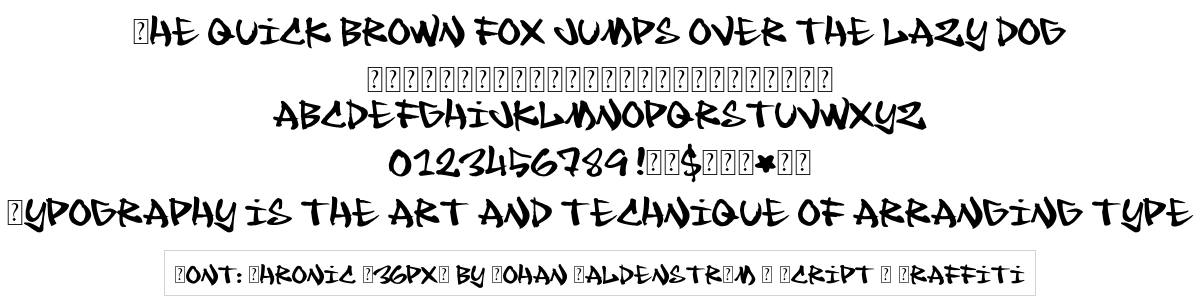

---
Score: 0.728
Font: aaaiight!_36px.png
Description: This font is a bold, handwritten style with a distinct graffiti aesthetic. The letters are thick and ...
Keywords: ['graffiti', 'handwritten', 'bold', 'rounded', 'streetwear', 'urban', 'casual', 'informal', 'youthful', 'fun', 'quirky', 'logo', 'poster', 'flyer', 't-shirt', 'design', 'packaging', 'social media', 'headline', 'title']


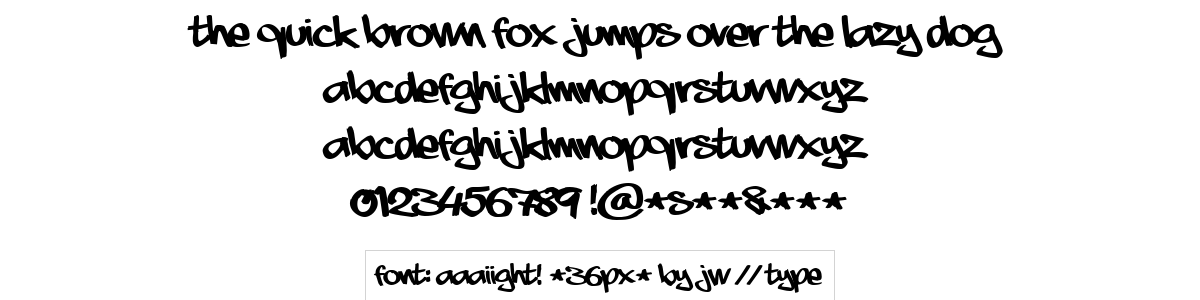

---
Score: 0.727
Font: blackbook_one_36px.png
Description: This font is a bold expression of urban energy, drawing heavily from the visual language of graffiti ...
Keywords: ['graffiti', 'street art', 'urban', 'bold', 'energetic', 'rebellious', 'spontaneous', 'unpolished', 'playful', 'raw', 'unconventional', 'expressive', 'freehand', 'dynamic', 'overlapping', 'exaggerated', 'sharp', 'thick', 'flourishes', 'headlines', 'posters', 'branding', 'youth', 'counterculture', 'individuality', 'self-expression']


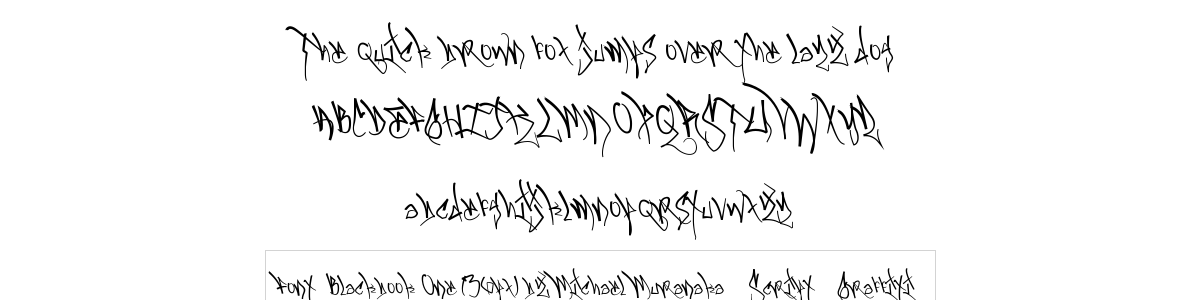

---

Searching for 'professional business typeface':
Score: 0.566
Font: dignity_of_labour_36px.png
Description: Dignity of Labour is a geometric sans-serif typeface with a distinct, almost mechanical aesthetic. I ...
Keywords: ['Geometric sans-serif', 'High x-height', 'Open counters', 'Sharp terminals', 'Bold', 'Modern', 'Minimalist', 'Digital', 'Branding', 'Editorial', 'User interface', 'Signage', 'Display', 'Strong', 'Reliable', 'Timeless']


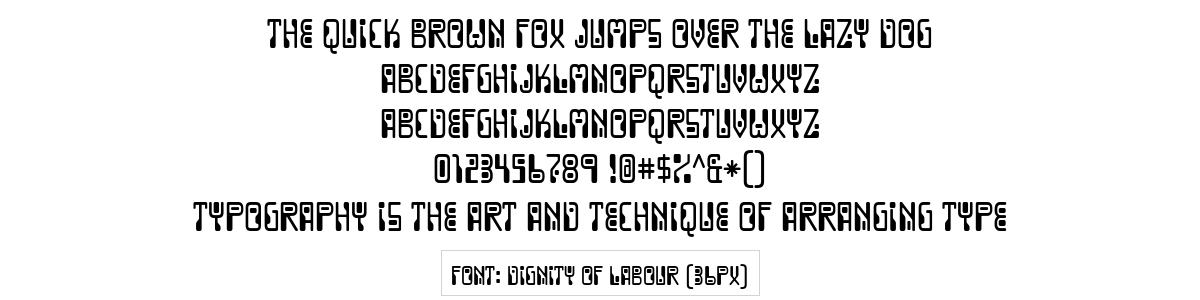

---
Score: 0.551
Font: 2006_team_36px.png
Description: The font appears to be a standard, sans-serif typeface commonly used for headlines and titles. It ex ...
Keywords: ['Sans-serif', 'Standard font', 'Headline font', 'Title font', 'Neutral font', 'Professional font', 'Clean font', 'Simple font', 'Legible font']


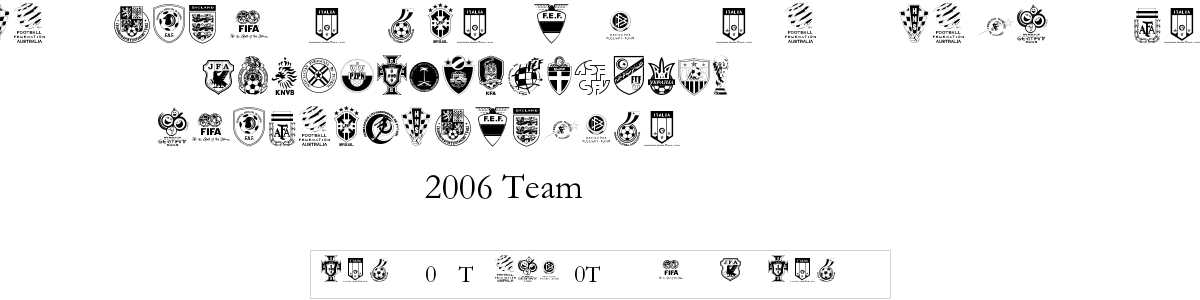

---
Score: 0.543
Font: bdp_oldneo_36px.png
Description: BDB OldNeo is a serif typeface that blends classic design principles with a contemporary sensibility ...
Keywords: ['serif typeface', 'geometric construction', 'humanist details', 'high x-height', 'open counters', 'rounded terminals', 'legible', 'versatile', 'modern', 'classic', 'professional', 'approachable', 'branding', 'editorial', 'web design', 'mobile design', 'corporate', 'display', 'headline', 'digital', 'print']


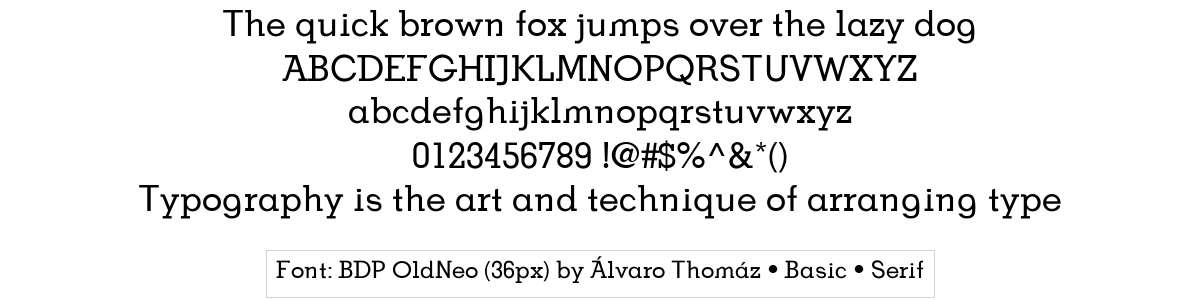

---
Score: 0.542
Font: 5_champagne_unicase_36px.png
Description: This font is a sans-serif typeface with a clean, modern aesthetic. It features a geometric construct ...
Keywords: ['Sans-serif', 'Geometric', 'Modern', 'Clean', 'Minimalist', 'Professional', 'Sophisticated', 'Bold', 'Branding', 'Logos', 'Web design', 'Print design', 'Headlines', 'Body text', 'Contemporary', 'International', 'Universal', 'Tech-forward']


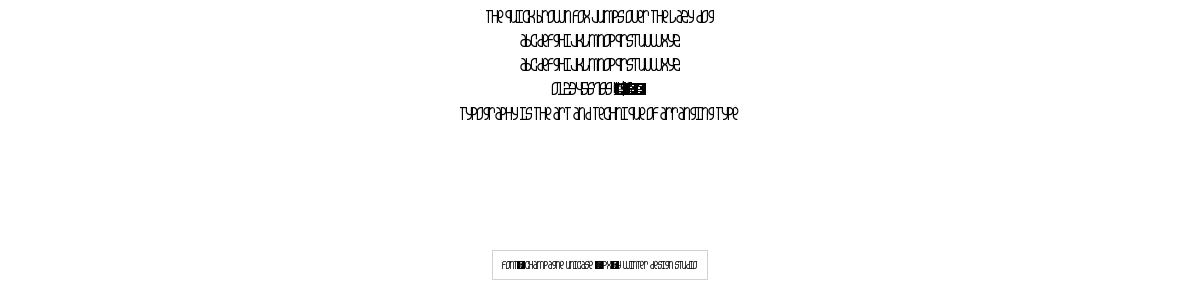

---
Score: 0.530
Font: brentonscrawltype_36px.png
Description: This font, with its bold, blocky forms and pronounced serifs, evokes a sense of vintage industrial d ...
Keywords: ['Geometric sans serif', 'Industrial font', 'Vintage typography', 'Bold display font', 'Legible typeface', 'High x-height', 'Open counters', 'Uneven spacing', 'Craft branding', 'Vintage design', 'Authenticity', 'Industrial aesthetic', 'Reclaimed materials', 'Handmade design']


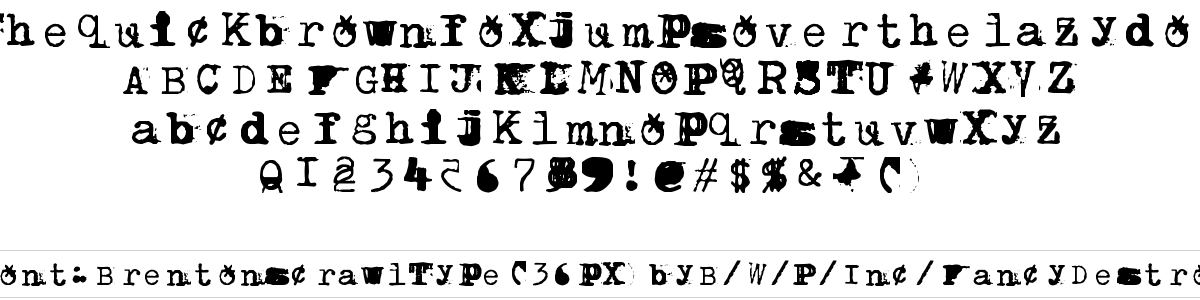

---

Searching for 'playful hand-drawn display font':
Score: 0.748
Font: classic_sketches_36px.png
Description: This font, crafted with a playful yet meticulous hand, presents a unique blend of whimsical charm an ...
Keywords: ['Hand-drawn', 'Organic', 'Rounded', 'Intricate', 'Playful', 'Whimsical', 'Charming', 'Graphic', 'Clear', 'Vintage', 'Contemporary', "Children's", 'Branding', 'Social media', 'Web design', 'Illustration', 'Display', 'Typography']


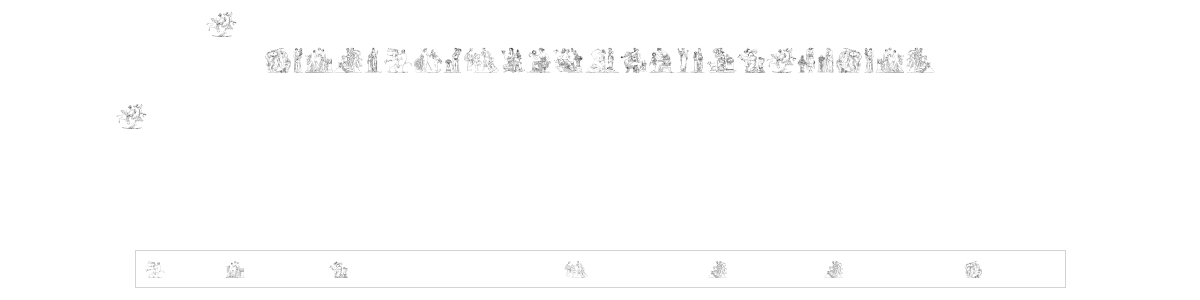

---
Score: 0.732
Font: children_animals_friends_36px.png
Description: This font is a playful and whimsical display typeface that uses animal illustrations as its glyphs.  ...
Keywords: ['Animal font', 'Display typeface', 'Whimsical font', 'Hand-drawn font', 'Cartoon font', "Children's font", 'Playful font', 'Nostalgic font', 'Nature font', 'Vintage font', 'Modern font', 'Digital font', 'Branding font', 'Logo font', 'Headline font', 'Illustration font', 'Black and white font', 'Unique font', 'Charming font', 'Fun font']


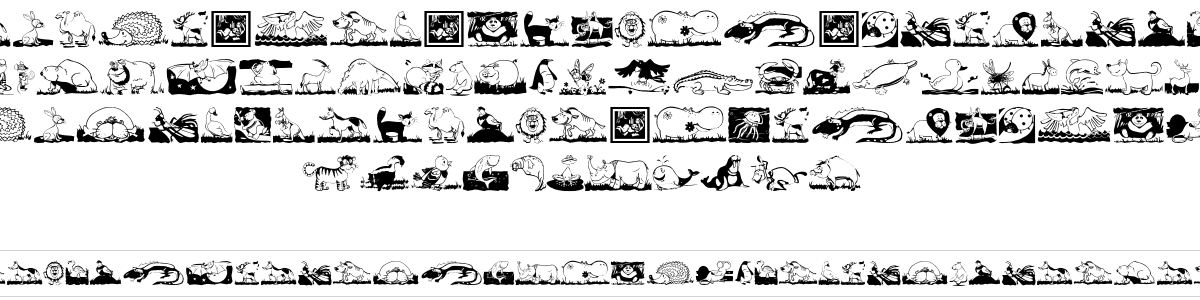

---
Score: 0.732
Font: chyld_36px.png
Description: This font is a playful and whimsical display typeface that uses simple linework and charming illustr ...
Keywords: ['Display typeface', 'Whimsical font', 'Cartoon font', "Children's font", 'Playful font', 'Nostalgic font', 'Simple linework', 'Geometric shapes', 'Organic shapes', 'Limited character set', 'Display typography', 'Branding', "Children's books", 'Websites', 'Packaging', 'Childhood', 'Family', 'Innocence', 'Joy', 'Nostalgia']


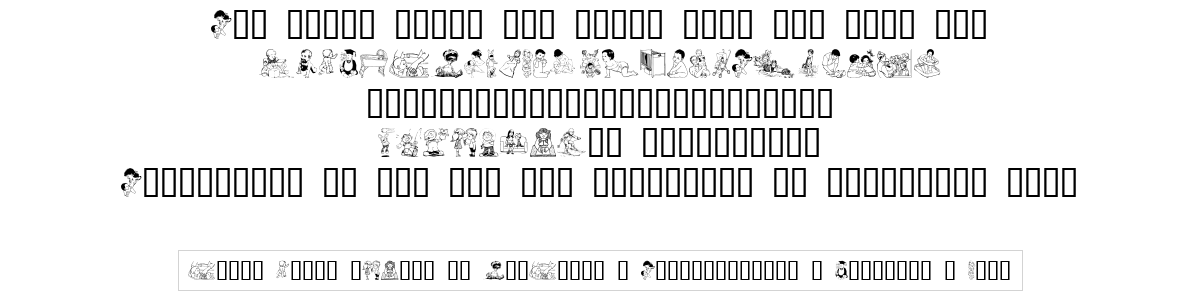

---
Score: 0.715
Font: crash_test_36px.png
Description: This font, with its exaggerated curves and playful proportions, embodies a sense of fun and energy.  ...
Keywords: ['Playful font', 'Casual font', 'Rounded font', 'Bold font', '3D font', 'Hand-drawn font', 'Comic font', 'Cartoon font', 'Nostalgic font', 'Modern font', 'Headline font', 'Logo font', 'Social media font', "Children's font", 'Branding font']


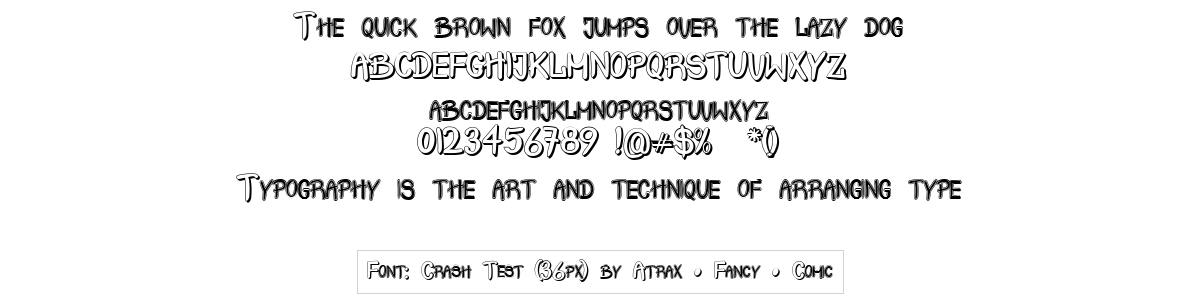

---
Score: 0.714
Font: bestioles_36px.png
Description: This font is a playful exploration of letterforms, each character transformed into a whimsical anima ...
Keywords: ['Whimsical font', 'Playful typeface', 'Hand-drawn font', 'Organic lettering', "Children's font", 'Creative font', 'Illustrative font', 'Fun font', 'Joyful font', 'Imaginative font', 'Animal font', 'Creature font', 'Cartoon font', 'Doodle font', 'Whimsical design', 'Playful branding', "Children's book font", 'Digital illustration font']


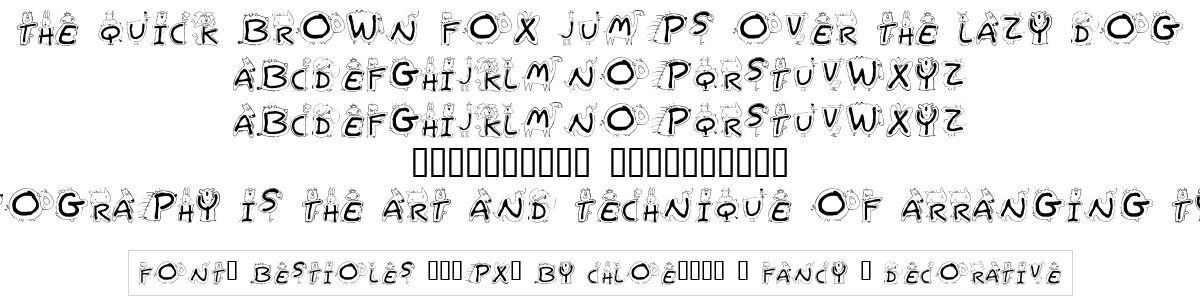

---


In [ ]:
# Example searches
queries = [
    "urban graffiti style font",
    "professional business typeface",
    "playful hand-drawn display font"
]
IMG_DIR = './rendered_fonts'

for query in queries:
    print(f"\nSearching for '{query}':")
    results = search2.search(query, k=5)
    for result in results:
        print(f"Score: {result['score']:.3f}")
        print(f"Font: {result['filename']}")
        print("Description:", result['description'][:100], "...")
        print("Keywords:", result['search_keywords'])
        
        # plot the image
        from PIL import Image
        img = Image.open(os.path.join(IMG_DIR, result['filename']))
        display(img)
        print("---")